In [71]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy import fft
from scipy.fftpack import dct, idct
from sklearn import linear_model
from pydub import AudioSegment
import os
import scipy.signal as sig
from tqdm import tqdm

from scipy.fftpack import dct, idct
from sklearn.linear_model import Lasso

from skimage.metrics import structural_similarity as ssim

import warnings
warnings.filterwarnings('ignore')

In [7]:
from scipy.fftpack import dct, idct
from sklearn.linear_model import Lasso

def compressive_sensing_random_sampling(signal, sampling_ratio, alpha):
    # Apply the DCT to the signal
    dct_signal = dct(signal, norm='ortho')

    # Randomly sample a fraction of the DCT coefficients
    num_samples = int(sampling_ratio * len(dct_signal))
    sampled_indices = np.sort(np.random.choice(len(dct_signal), num_samples, replace=False))
    sampled_dct_signal = dct_signal[sampled_indices]

    # Create a matrix with rows corresponding to the selected DCT coefficients
    A = np.zeros((num_samples, len(dct_signal)))
    for i, index in (enumerate(sampled_indices)):
        A[i, index] = 1.0

    # Set up the Lasso regression model
    lasso = Lasso(alpha=alpha)

    # Fit the Lasso model to the sampled DCT coefficients
    lasso.fit(A, sampled_dct_signal)

    # Predict all DCT coefficients
    recovered_dct_signal = lasso.predict(np.eye(len(dct_signal)))
    
    # Apply the inverse DCT to obtain the recovered signal
    recovered_signal = idct(recovered_dct_signal, norm='ortho')

    return recovered_signal

In [121]:
from skimage import color, data
from skimage.transform import rescale

img = color.rgb2gray(data.astronaut())*256
img = rescale(img, 0.25, anti_aliasing=False)
img = img - len(img)

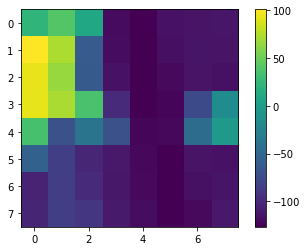

In [201]:
i = j = 0
block = img[8*i:8*(i+1), 8*j:8*(j+1)]
plt.imshow(block)
plt.colorbar()

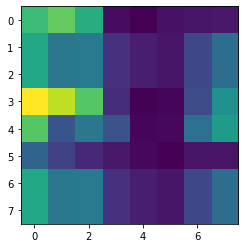

In [207]:
reconstruction = compressive_sensing_random_sampling(block, sampling_ratio = 0.50
                                                     , alpha=0.1)
plt.imshow(reconstruction, cmap = 'viridis')
# plt.colorbar()

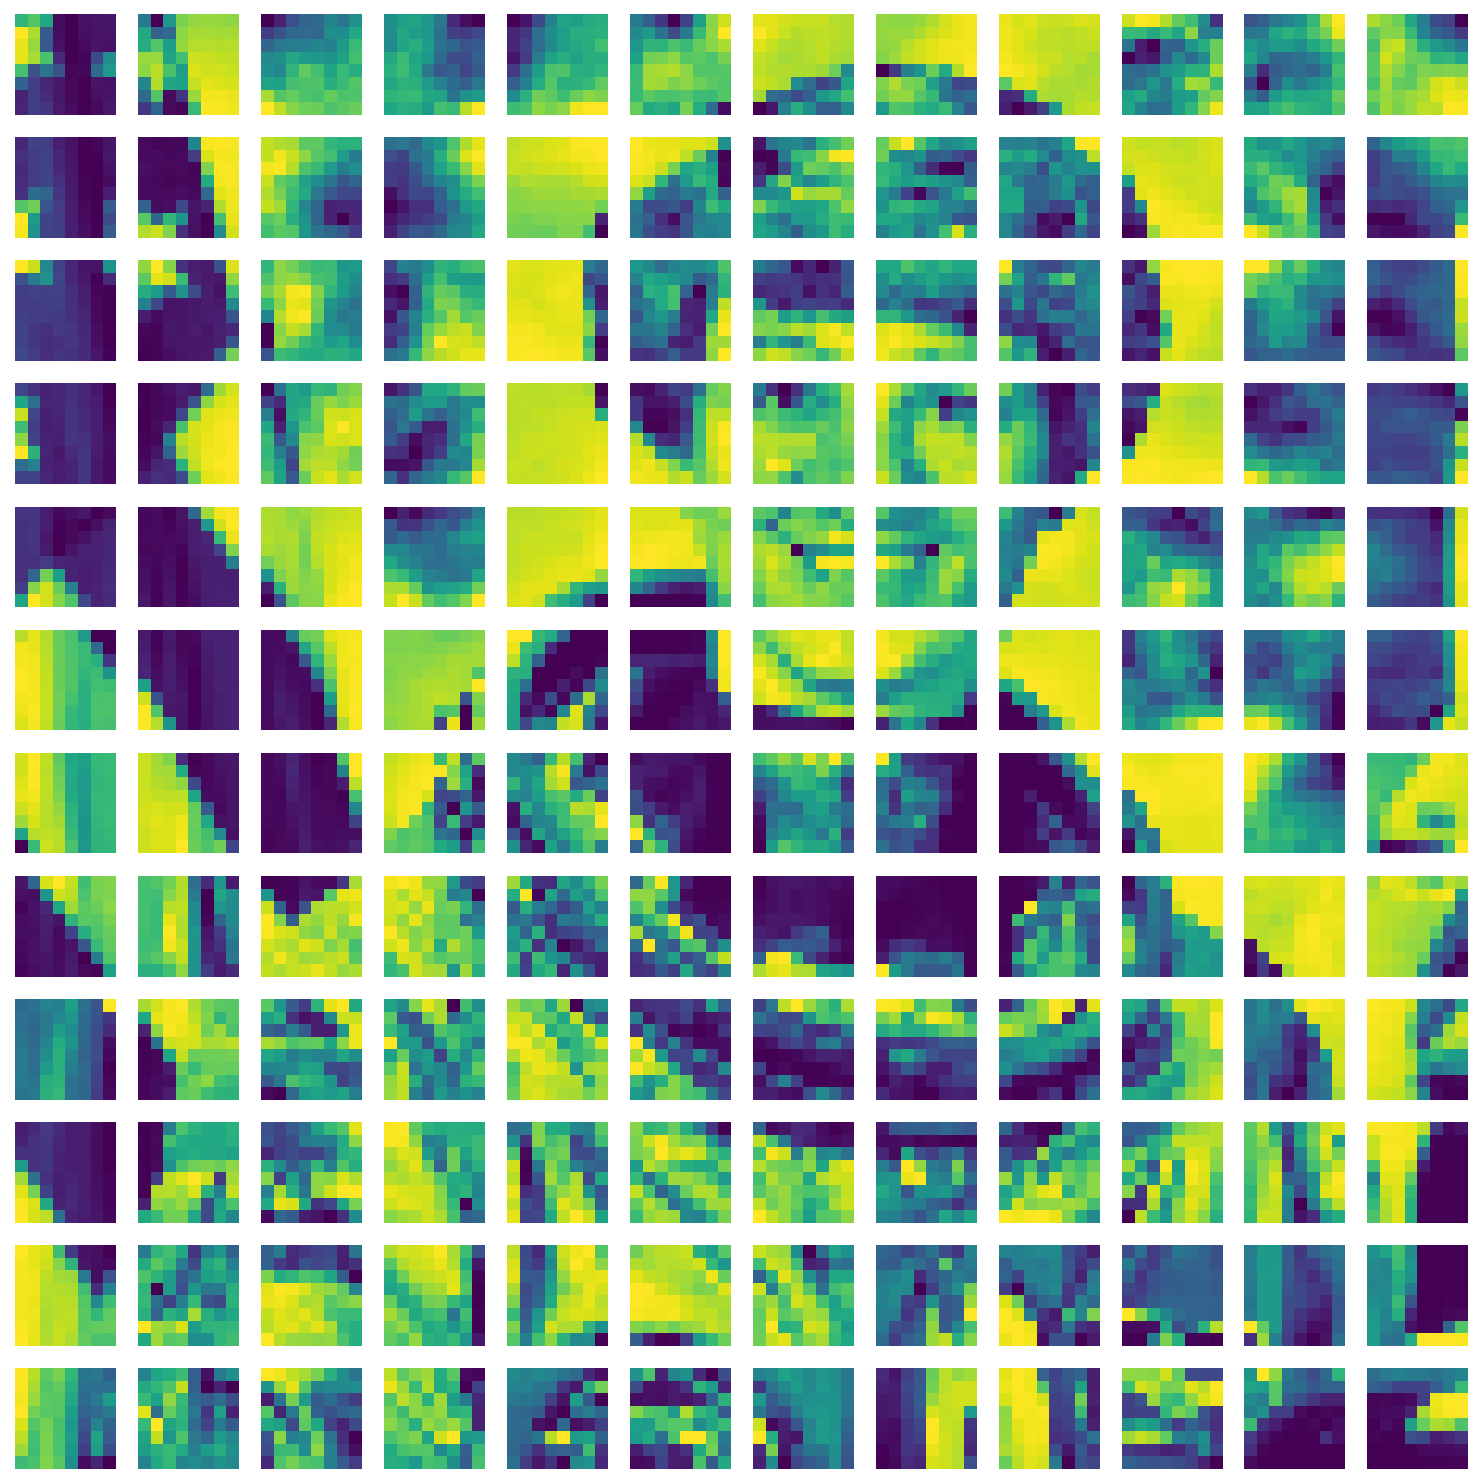

In [5]:
block_size = 8
windows = int(img.shape[0]/block_size)

plt.figure(dpi = 150, figsize = (10,10))
for i in range(windows):
    for j in range(windows):
        n = (i*12+j)+1
        if n <= 144:
            plt.subplot(12,12,n)
            block = img[8*i:8*(i+1), 8*j:8*(j+1)]
            plt.imshow(block)        
            plt.axis('off')            
plt.tight_layout()

In [28]:
def CS_img(img, sampling_ratio, alpha):
    recovered = np.zeros(img.shape)
    block_size = 8
    windows = int(img.shape[0]/block_size)

    for i in range(windows):
        for j in range(windows):
            n = (i*12+j)+1
    #         if n <= 144:
            block = img[block_size*i:block_size*(i+1), block_size*j:block_size*(j+1)];
            reconstruction = compressive_sensing_random_sampling(block, sampling_ratio, alpha=alpha)
            recovered[block_size*i:block_size*(i+1), block_size*j:block_size*(j+1)] = reconstruction

    return recovered

In [74]:
# plt.figure(dpi = 150, figsize = (10,6))

# sampling_rates = np.linspace(0.15,0.60,10)
# for sampling in sampling_rates:
#     plt.subplot(2,5,1)
#     plt.imshow(img)
#     plt.title('Original')
#     n = sampling_rates.tolist().index(sampling)
#     plt.subplot(2,5,n+1)
#     recovered = CS_img(img, sampling_ratio = sampling, alpha=0.1)
#     plt.imshow(recovered)
#     plt.title(str(int(sampling*100)) + " %")
#     plt.axis('off')            
# plt.tight_layout()
# plt.show()

In [126]:
np.arange(0, len(img)+1, len(img)/2)

array([  0.,  64., 128.])

## Image Size: 128 by 128

In [175]:
img = color.rgb2gray(data.astronaut())*256
img = rescale(img, 0.25, anti_aliasing=False)
img = img - len(img)

100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.06it/s]


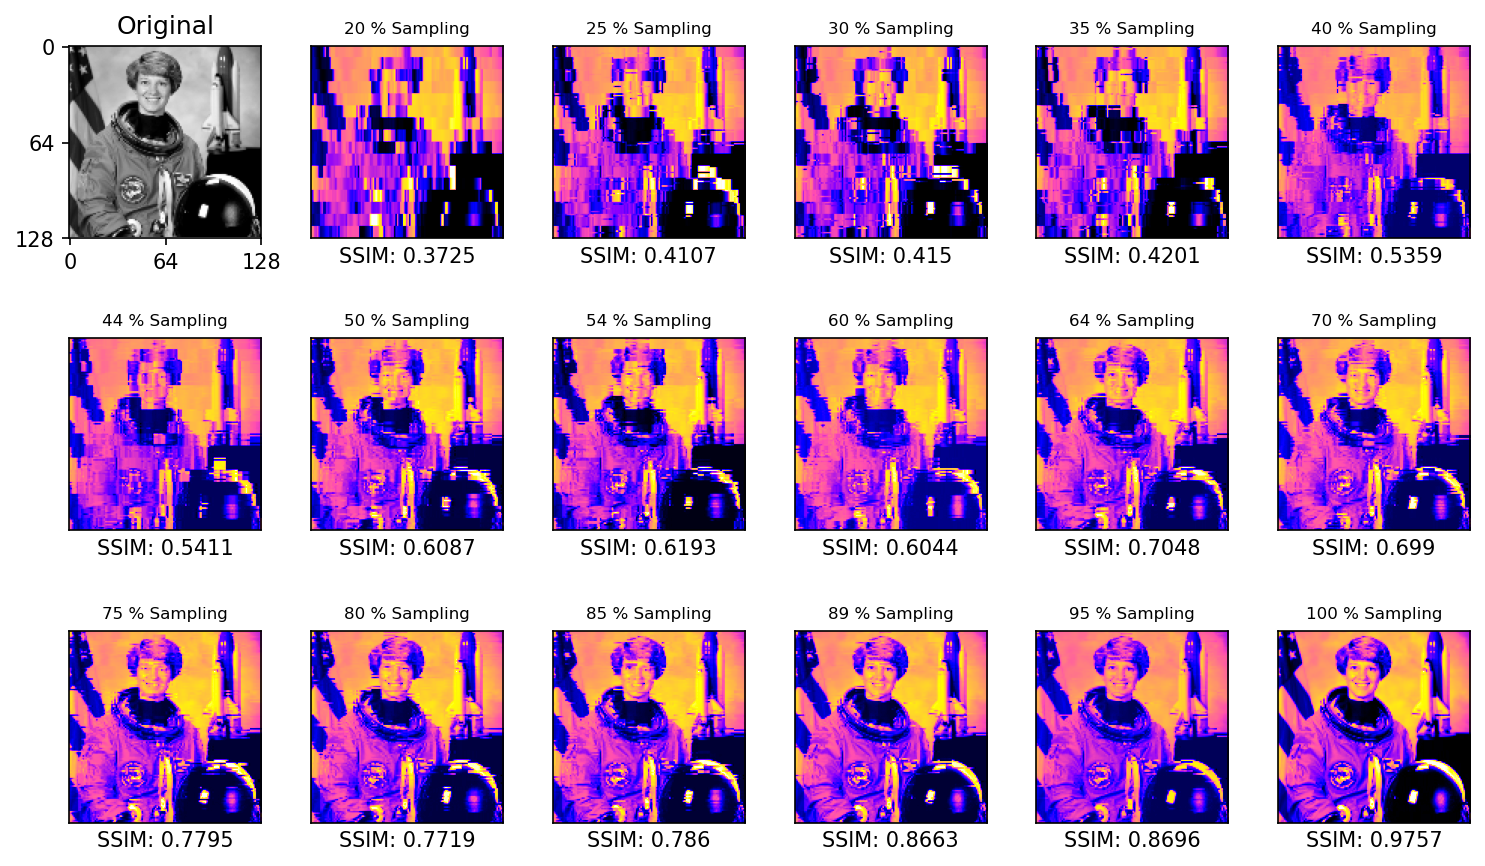

In [176]:
cmap = 'gnuplot2'

plt.figure(dpi = 150, figsize = (10,6))
sampling_rates = np.linspace(0.15,1,18)

for sampling in tqdm(sampling_rates):
    plt.subplot(3,6,1)
    plt.imshow(img, 'gray')
    plt.xticks(np.arange(0, len(img)+1, len(img)/2))                
    plt.yticks(np.arange(0, len(img)+1, len(img)/2))  
    plt.title('Original')
    
    n = sampling_rates.tolist().index(sampling)
    plt.subplot(3,6,n+1)
    recovered = CS_img(img, sampling_ratio = sampling, alpha=0.1)
    plt.imshow(recovered, cmap = cmap)
    SSIM = ssim(img, recovered)
    if n != 0:
        plt.title(str(int(sampling*100)) + " % Sampling", fontsize = 8)  
        plt.xlabel('SSIM: ' + str(np.round(SSIM,4)))
        plt.xticks([])                
        plt.yticks([])       
    
plt.tight_layout()
plt.show()

In [177]:
sampling_rates = np.arange(0.15,1,0.01)
SSIM_list = []
for sampling in tqdm(sampling_rates):
    recovered = CS_img(img, sampling_ratio = sampling, alpha=0.1)
    SSIM_list.append(ssim(img, recovered))

100%|███████████████████████████████████████████| 85/85 [00:13<00:00,  6.23it/s]


(0.0, 1.0)

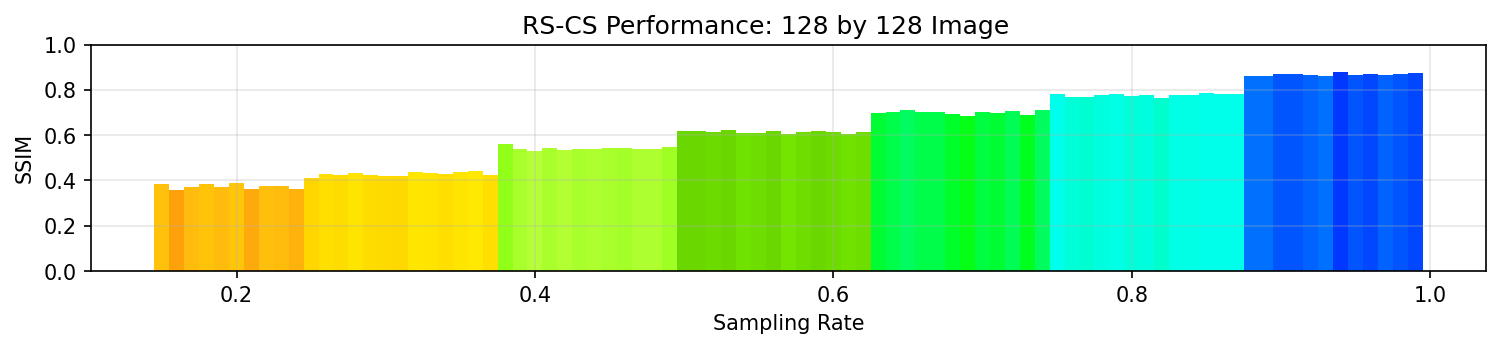

In [179]:
plt.figure(figsize=(12,2), dpi = 150)
plt.suptitle("RS-CS Performance: 128 by 128 Image")
plt.grid(alpha = 0.3)
plt.bar(sampling_rates,SSIM_list,
        color = plt.cm.gist_ncar_r(SSIM_list), width = 0.01)

plt.ylabel("SSIM")
plt.xlabel("Sampling Rate")
plt.ylim(0,1)

## Image Size: 256 by 256

In [137]:
img = color.rgb2gray(data.astronaut())*256
img = rescale(img, 0.5, anti_aliasing=False)
img = img - len(img)

100%|███████████████████████████████████████████| 18/18 [00:12<00:00,  1.45it/s]


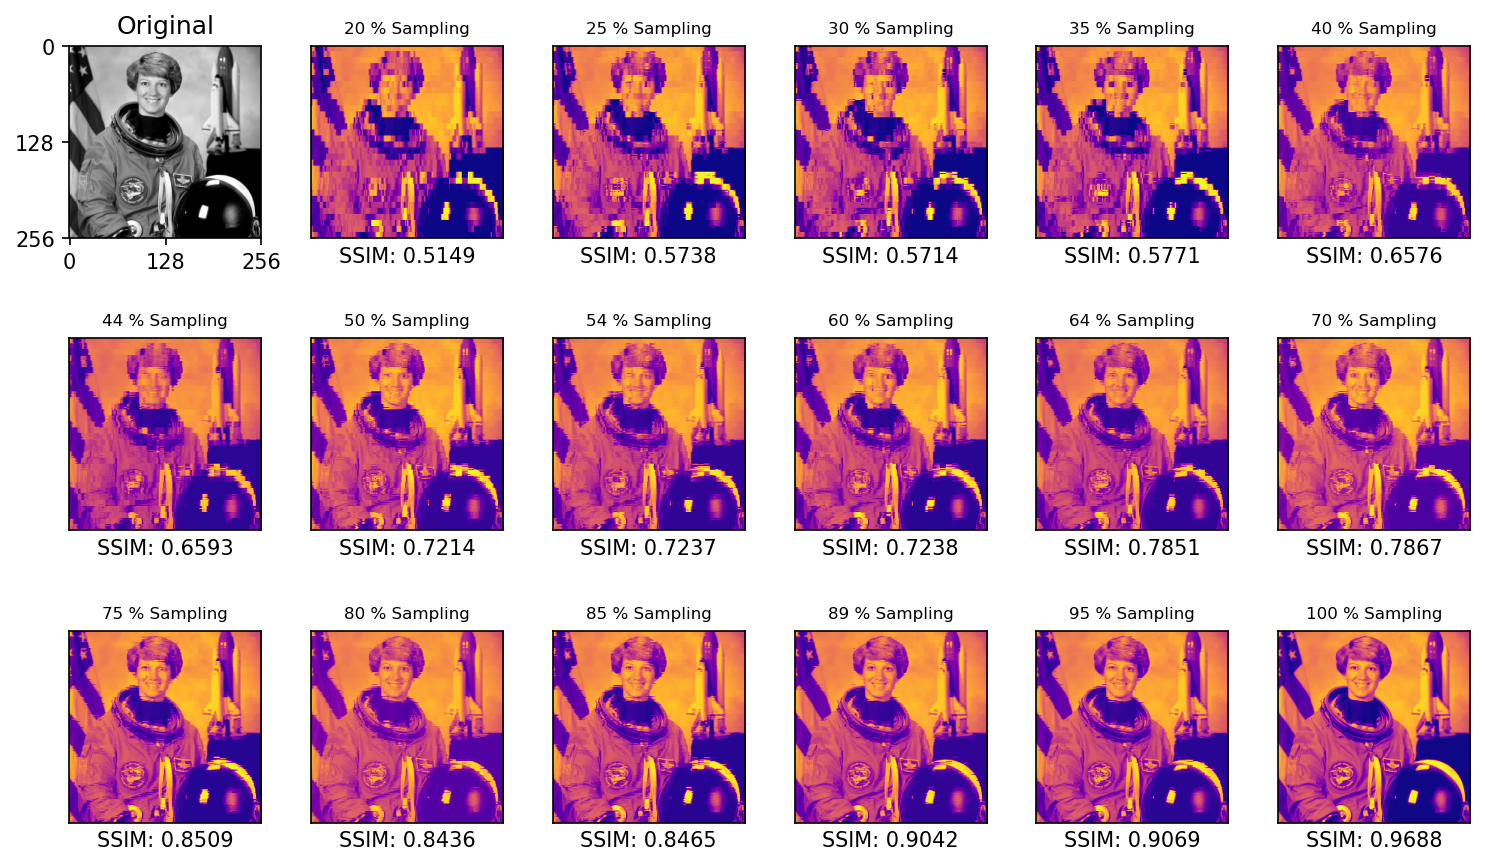

In [138]:
cmap = 'plasma'

plt.figure(dpi = 150, figsize = (10,6))
sampling_rates = np.linspace(0.15,1,18)

for sampling in tqdm(sampling_rates):
    plt.subplot(3,6,1)
    plt.imshow(img, 'gray')
    plt.xticks(np.arange(0, len(img)+1, len(img)/2))                
    plt.yticks(np.arange(0, len(img)+1, len(img)/2))  
    plt.title('Original')
    
    n = sampling_rates.tolist().index(sampling)
    plt.subplot(3,6,n+1)
    recovered = CS_img(img, sampling_ratio = sampling, alpha=0.1)
    plt.imshow(recovered, cmap = cmap)
    SSIM = ssim(img, recovered)
    if n != 0:
        plt.title(str(int(sampling*100)) + " % Sampling", fontsize = 8)  
        plt.xlabel('SSIM: ' + str(np.round(SSIM,4)))
        plt.xticks([])                
        plt.yticks([])       
        
plt.tight_layout()
plt.show()

In [140]:
sampling_rates = np.arange(0.15,1,0.01)
SSIM_256 = []
for sampling in tqdm(sampling_rates):
    recovered = CS_img(img, sampling_ratio = sampling, alpha=0.1)
    SSIM_256.append(ssim(img, recovered))

100%|███████████████████████████████████████████| 85/85 [00:57<00:00,  1.48it/s]


(0.0, 1.0)

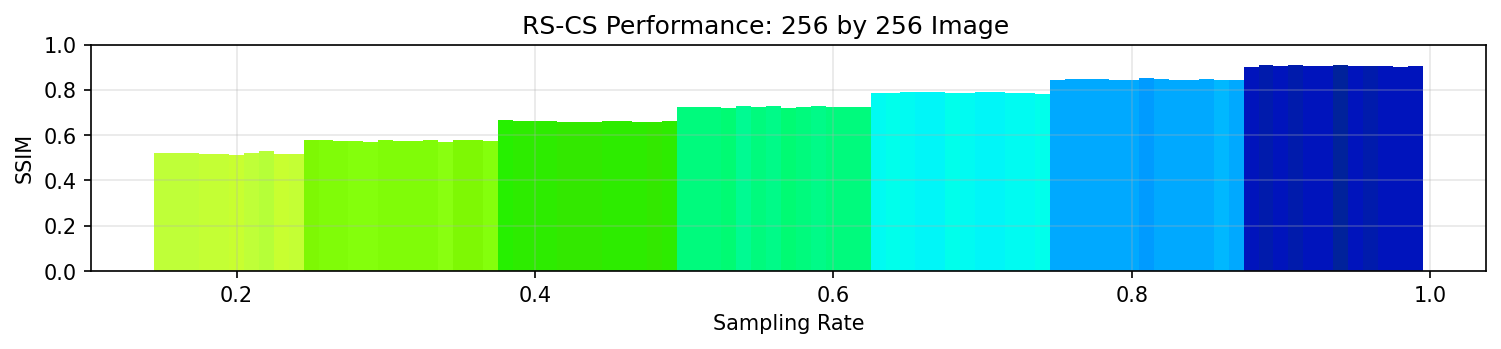

In [180]:
plt.figure(figsize=(12,2), dpi = 150)
plt.suptitle("RS-CS Performance: 256 by 256 Image")
plt.grid(alpha = 0.3)
plt.bar(sampling_rates,SSIM_256,
        color = plt.cm.gist_ncar_r(SSIM_256), width = 0.01)
# plt.title('Horizontal Blur')
plt.ylabel("SSIM")
plt.xlabel("Sampling Rate")
plt.ylim(0,1)

## Image Size: 512 by 512

In [143]:
img = color.rgb2gray(data.astronaut())*256
img = img - len(img)

100%|███████████████████████████████████████████| 18/18 [00:55<00:00,  3.09s/it]


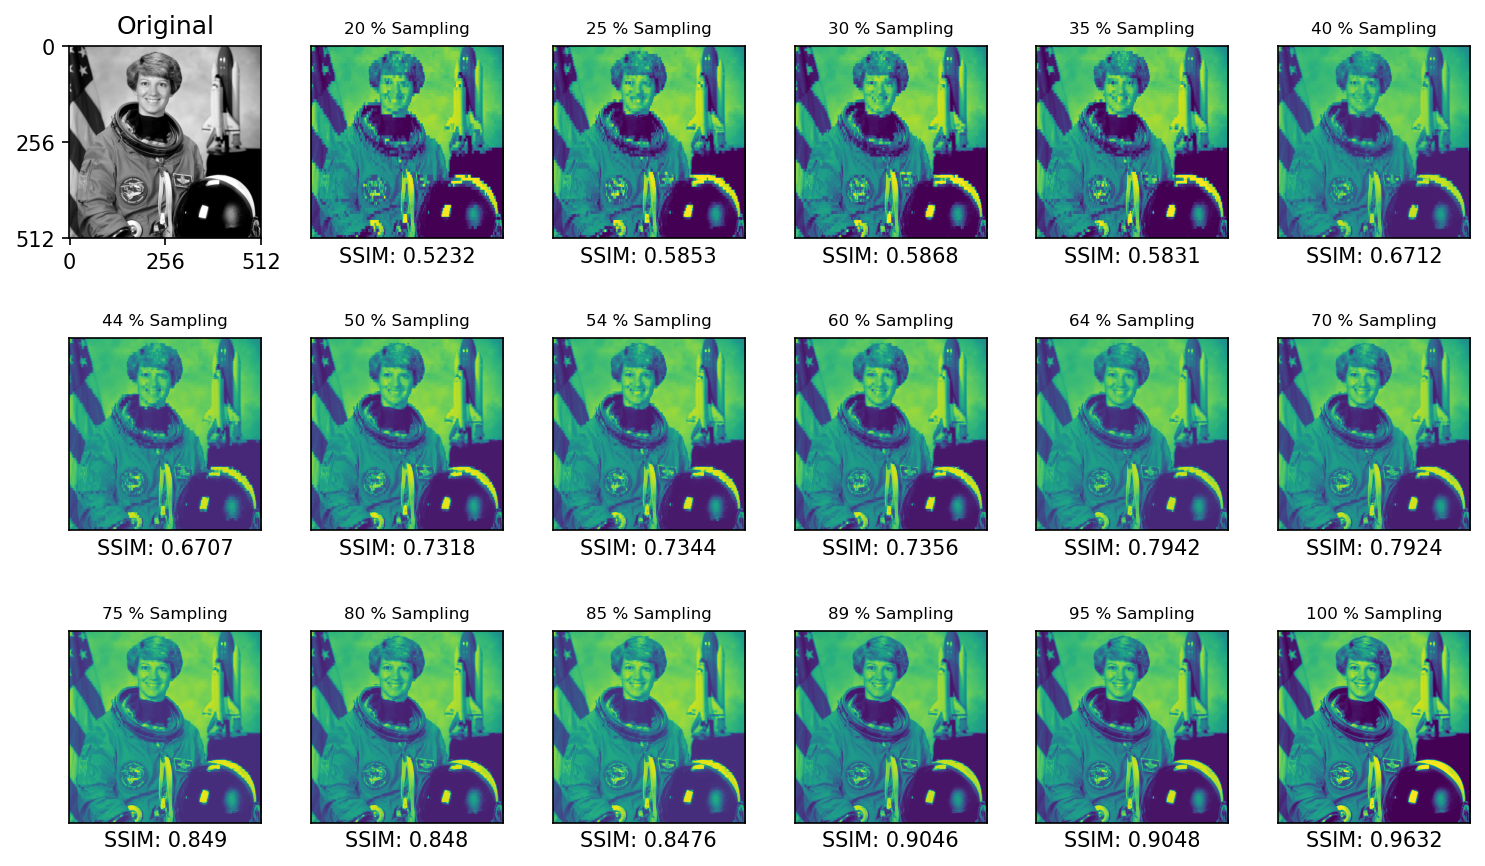

In [144]:
cmap = 'viridis'

plt.figure(dpi = 150, figsize = (10,6))
sampling_rates = np.linspace(0.15,1,18)

for sampling in tqdm(sampling_rates):
    plt.subplot(3,6,1)
    plt.imshow(img, 'gray')
    plt.xticks(np.arange(0, len(img)+1, len(img)/2))                
    plt.yticks(np.arange(0, len(img)+1, len(img)/2))  
    plt.title('Original')
    
    n = sampling_rates.tolist().index(sampling)
    plt.subplot(3,6,n+1)
    recovered = CS_img(img, sampling_ratio = sampling, alpha=0.1)
    plt.imshow(recovered, cmap = cmap)
    SSIM = ssim(img, recovered)
    if n != 0:
        plt.title(str(int(sampling*100)) + " % Sampling", fontsize = 8)  
        plt.xlabel('SSIM: ' + str(np.round(SSIM,4)))
        plt.xticks([])                
        plt.yticks([])               
plt.tight_layout()
plt.show()

In [145]:
sampling_rates = np.arange(0.15,1,0.01)
SSIM_512 = []
for sampling in tqdm(sampling_rates):
    recovered = CS_img(img, sampling_ratio = sampling, alpha=0.1)
    SSIM_512.append(ssim(img, recovered))

100%|███████████████████████████████████████████| 85/85 [04:10<00:00,  2.95s/it]


(0.0, 1.0)

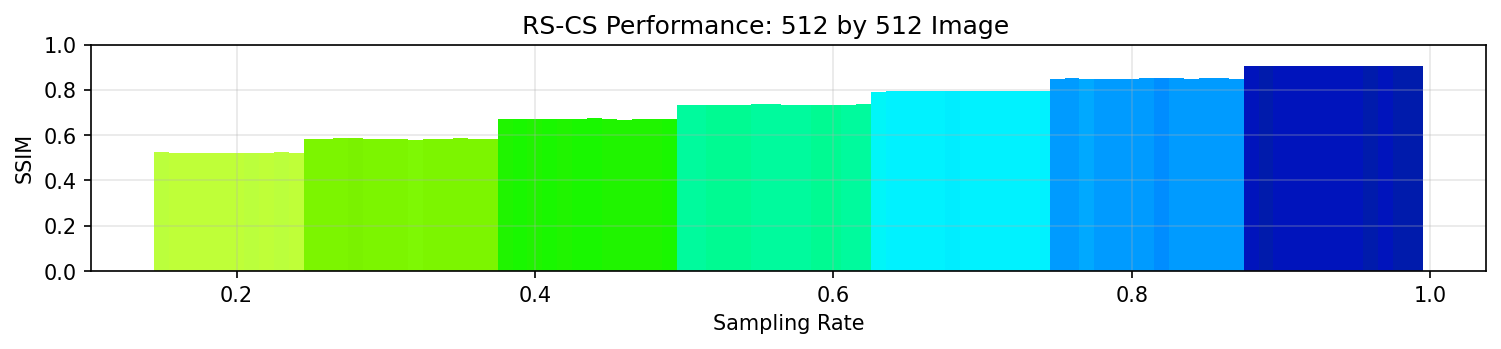

In [181]:
plt.figure(figsize=(12,2), dpi = 150)
plt.suptitle("RS-CS Performance: 512 by 512 Image")
plt.grid(alpha = 0.3)
plt.bar(sampling_rates,SSIM_512,
        color = plt.cm.gist_ncar_r(SSIM_512), width = 0.01)
# plt.title('Horizontal Blur')
plt.ylabel("SSIM")
plt.xlabel("Sampling Rate")
plt.ylim(0,1)